# FAST version of the notebook:
# *Faster than training from scratch - Fine-tuning the English GPT-2 in any language with Hugging Face and fastai v2 (practical case with Portuguese)*

> Tutorial on how to use fastai v2 over Hugging Face's Transformers and Tokenizers libraries to fine-tune an English pre-trained transformer-based language model (GPT-2) to any language other than English

- Author: [Pierre Guillou](https://www.linkedin.com/in/pierreguillou)
- Date: July 2020 (14/07/2020)
- Post in medium: [Faster than training from scratch - Fine-tuning the English GPT-2 in any language with Hugging Face and fastai v2 (practical case with Portuguese)](https://medium.com/@pierre_guillou/faster-than-training-from-scratch-fine-tuning-the-english-gpt-2-in-any-language-with-hugging-f2ec05c98787)
- Notebook with all explanation: [finetuning-English-GPT2-any-language-Portuguese-HuggingFace-fastaiv2.ipynb](https://github.com/piegu/fastai-projects/blob/master/finetuning-English-GPT2-any-language-Portuguese-HuggingFace-fastaiv2.ipynb)
- Hugging face model page of [GPorTuguese-2](https://huggingface.co/pierreguillou/gpt2-small-portuguese): a language model for Portuguese text generation (and more NLP tasks...)
- Other posts in medium of the GPT-2 series: 
  - [NLP & fastai | GPT-2](https://medium.com/@pierre_guillou/nlp-fastai-gpt-2-16ee145a4a28)
  - [Byte-level BPE, an universal tokenizer but...](https://medium.com/@pierre_guillou/byte-level-bpe-an-universal-tokenizer-but-aff932332ffe)

## Overview

In this tutorial, instead of training from scratch, we will see how to fine-tune in just over a day, on one GPU and with a little more than 1GB of training data an English pre-trained [transformer](https://arxiv.org/abs/1706.03762)-based language model to any another language. 

As a practical case, we fine-tune to Portuguese the [English pre-trained GPT-2](https://github.com/openai/gpt-2) by wrapping the [Transformers](https://github.com/huggingface/transformers) and [Tokenizers](https://github.com/huggingface/tokenizers) libraries of Hugging Face into [fastai v2](https://github.com/fastai/fastai2). We thus create a new language model: [GPorTuguese-2](https://huggingface.co/pierreguillou/gpt2-small-portuguese), a language model for Portuguese text generation (and more NLP tasks...).

![The 3 main steps of fine-tuning the English GPT-2 to Portuguese with Hugging Face and fastai v2 (image edited from fast.ai NLP)](images/GPT2_tf_ft_approach.png "The 3 main steps of fine-tuning the English GPT-2 to Portuguese with Hugging Face and fastai v2 (image edited from fast.ai NLP)")

## Acknowledgment

This tutorial was made possible thanks to the computing power of the [AI Lab](https://www.linkedin.com/company/ailab-unb/) (University of Brasilia) to which I am attached as an Associate Researcher in NLP and the participation of its directors in the definition of the NLP strategy, Professors [Fabricio Ataides Braz](https://www.linkedin.com/in/fabricio-braz-b356457/) and [Nilton Correia da Silva](https://www.linkedin.com/in/nilton-silva-6097853/). Thank you so much!

And special thanks to Sylvain Gugger for his [tutorial on Transformers and fastai v2](https://dev.fast.ai/tutorial.transformers) which is the basis of this tutorial.

## Post, notebooks, Web App and model download

The main code of the tutorial is published in this post ([Faster than training from scratch - Fine-tuning the English GPT-2 in any language with Hugging Face and fastai v2 (practical case with Portuguese)](https://medium.com/@pierre_guillou/faster-than-training-from-scratch-fine-tuning-the-english-gpt-2-in-any-language-with-hugging-f2ec05c98787)), organized by paragraph. 

The complete code is in this notebook. However, as this notebook is very detailed, you can use this fast notebook finetuning-English-GPT2-any-language-Portuguese-HuggingFace-fastaiv2_FAST.ipynb (nbviewer version) if you just want to execute the code without explanation.

In addition, our **GPorTuguese-2 (Portuguese GPT-2 small) , a language model for Portuguese text generation (and more NLP tasks...)**, is testable online in the [Hugging face model hub](https://huggingface.co/models) with all usage information at this address: https://huggingface.co/pierreguillou/gpt2-small-portuguese

![GPorTuguese-2 (Portuguese GPT-2 small) , a language model for Portuguese text generation (and more NLP tasks...)](images/hfmh.png "GPorTuguese-2 (Portuguese GPT-2 small) , a language model for Portuguese text generation (and more NLP tasks...)")

## Main coding steps to fine-tune a Hugging Face language model with fastai v2

The 6 main steps detailed below can be summarized in 3 main ones:

1. **Initialization & download** (download of Portuguese Wikipedia and GPT-2 English pre-trained model and tokenizer)
2. **GPT-2 tokenizer with a Portuguese vocab** (train a GPT-2 tokenizer with a vocab in Portuguese, wrap it into a fastai v2 tokenizer and update the embeddings matrix of the GPT-2 English pre-trained model according to the new Portuguese vocab: keep the embeddings vectors of the common tokens between English and Portuguese vocabs)
3. **Fine-tune on Portuguese Wikipedia the GPT-2 model with fastai v2 training functionalities**

### 1. Initialization

In [1]:
from fastai2.text.all import *
from nlputils_fastai2 import * 

%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
gpu = 0
torch.cuda.set_device(gpu)
print(f'cuda device: {torch.cuda.current_device()}')
# print(f'cuda device name: {torch.cuda.get_device_name(gpu)}')

cuda device: 0


In [3]:
# Get config of paths
config = Config()
config.d

{'archive_path': '/storage/archive/',
 'data_path': '/storage/data/',
 'model_path': '/storage/models/',
 'storage_path': '/storage/data/',
 'version': 2}

This will create a `{lang}wiki` folder, containing a `{lang}wiki` text file with the wikipedia contents. (For other languages, replace `{lang}` with the appropriate code from the [list of wikipedias](https://meta.wikimedia.org/wiki/List_of_Wikipedias).)

In [4]:
lang = 'pt'

In [5]:
# setup new path_data and create the corresponding folder
name = f'{lang}wiki'
data_path = config['data_path']
path_data = data_path/name
path_data.mkdir(exist_ok=True, parents=True)

### 2. Download Wikipedia in Portuguese

**Note**: all the following methods come from the file nlputils_fastai2.py.

In [5]:
Path.cwd(), path_data

(Path('/mnt/home/pierre/course-v4/nbs'),
 Path('/mnt/home/pierre/.fastai/data/ptwiki'))

In [6]:
get_wiki(path_data,lang)

/mnt/home/pierre/.fastai/data/ptwiki/ptwiki already exists; not downloading


If `get_wiki(path_data,lang)` breaks, fix the download manually no terminal:
- mkdir -p /mnt/home/pierre/.fastai/data/ptwiki
- cd /mnt/home/pierre/.fastai/data/ptwiki
- wget -c https://dumps.wikimedia.org/ptwiki/latest/ptwiki-latest-pages-articles.xml.bz2
- bzip2 -dk ptwiki-latest-pages-articles.xml.bz2

And re-run `get_wiki(path_data,lang)` once the download is successful.

In [7]:
!head -n4 {path_data}/{name}

<doc id="220" url="https://pt.wikipedia.org/wiki?curid=220" title="Astronomia">
Astronomia

Astronomia é uma ciência natural que estuda corpos celestes (como estrelas, planetas, cometas, nebulosas, aglomerados de estrelas, galáxias) e fenômenos que se originam fora da atmosfera da Terra (como a radiação cósmica de fundo em micro-ondas). Preocupada com a evolução, a física, a química e o movimento de objetos celestes, bem como a formação e o desenvolvimento do universo.


In [8]:
dest = split_wiki(path_data,lang)

/mnt/home/pierre/.fastai/data/ptwiki/docs already exists; not splitting


In [9]:
dest = path_data/'docs'
for file in dest.ls()[:5]:
    print(file)

/mnt/home/pierre/.fastai/data/ptwiki/docs/Fotografia.txt
/mnt/home/pierre/.fastai/data/ptwiki/docs/Espadanedo (Macedo de Cavaleiros).txt
/mnt/home/pierre/.fastai/data/ptwiki/docs/Jacques-Germain Soufflot.txt
/mnt/home/pierre/.fastai/data/ptwiki/docs/Faculdade de Medicina da Universidade de São Paulo.txt
/mnt/home/pierre/.fastai/data/ptwiki/docs/Escola do Teatro Bolshoi no Brasil.txt


In [33]:
%%time
# Size of downloaded data in the docs folder
num_files, num_tokens = get_num_tokens(dest)
print(f'{num_files} files - {num_tokens} tokens')

203205 files - 193686269 tokens
CPU times: user 1min, sys: 20.8 s, total: 1min 21s
Wall time: 11min 16s


#### Create text and csv files of wikipedia in Portuguese

In [ ]:
dest = path_data/'docs'

##### Text file

In [ ]:
%%time
get_one_clean_file(dest,lang)

##### csv file

In [ ]:
%%time
get_one_clean_csv_file(dest,lang)

### 3. Download a GPT-2 English pre-trained model and train a GPT-2 tokenizer with a vocab in Portuguese

We are following 3 steps in order to **get a GPT-2 tokenizer with the vocab in Portuguese**:
- 3.1) **Get the pre-trained GPT-2 Tokenizer & Model (pre-training with an English corpus) from the Transformers library (Hugging Face)**: it will give us the tokenizer structure we need and the pre-trained model weights (it's better to start training our GPT-2 model in Portuguese from weights already trained even in another language than from random values)
- 3.2) **Train a Byte-level BPE (BBPE) Tokenizer on the Portuguese Wikipedia corpus by using the Tokenizers library (Hugging Face)**: this will give us the vocabulary files in Portuguese of our GPT-2 tokenizer.
- 3.3) **Import the tokenizer Portuguese config files into the pre-trained GPT-2 Tokenizer**: it will give us a GPT-2 tokenizer structure with the vocab in Portuguese.

#### 3.1 Get the pre-trained GPT2 Tokenizer & Model (pre-training with an English corpus)

In [6]:
# ! pip install transformers
!pip freeze | grep transformers

transformers==3.0.0


In [7]:
from transformers import GPT2TokenizerFast, GPT2LMHeadModel

In [8]:
%%time
pretrained_weights = 'gpt2'
tokenizer_en = GPT2TokenizerFast.from_pretrained(pretrained_weights)
model_en = GPT2LMHeadModel.from_pretrained(pretrained_weights)

Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.attn.masked_bias', 'h.1.attn.masked_bias', 'h.2.attn.masked_bias', 'h.3.attn.masked_bias', 'h.4.attn.masked_bias', 'h.5.attn.masked_bias', 'h.6.attn.masked_bias', 'h.7.attn.masked_bias', 'h.8.attn.masked_bias', 'h.9.attn.masked_bias', 'h.10.attn.masked_bias', 'h.11.attn.masked_bias', 'lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


CPU times: user 13 s, sys: 922 ms, total: 13.9 s
Wall time: 7.48 s


In [9]:
# To correct the warning about token_pad (GPT2TokenizerFast), run the following code
# source: https://github.com/huggingface/transformers/issues/2648#issuecomment-616177044
tokenizer_en.pad_token = tokenizer_en.eos_token

#### 3.2 Train a Byte Level BPE (BBPE) Tokenizer on the Portuguese Wikipedia

In [12]:
# !pip install tokenizers
!pip freeze | grep tokenizers

tokenizers==0.8.0


##### Training

In [13]:
# Get GPT2 tokenizer_en vocab size
ByteLevelBPE_tokenizer_pt_vocab_size = tokenizer_en.vocab_size
ByteLevelBPE_tokenizer_pt_vocab_size

50257

In [13]:
%%time
# ByteLevelBPETokenizer Represents a Byte-level BPE as introduced by OpenAI with their GPT-2 model
from tokenizers import ByteLevelBPETokenizer

ByteLevelBPE_tokenizer_pt = ByteLevelBPETokenizer()

# Get list of paths to corpus files
paths = [str(path_data/'all_texts_ptwiki.txt')]

# Customize training with <|endoftext|> special GPT2 token
ByteLevelBPE_tokenizer_pt.train(files=paths, 
                                vocab_size=ByteLevelBPE_tokenizer_pt_vocab_size, 
                                min_frequency=2, 
                                special_tokens=["<|endoftext|>"])

# Get sequence length max of 1024
ByteLevelBPE_tokenizer_pt.enable_truncation(max_length=1024)

# save tokenizer
ByteLevelBPE_tokenizer_pt_rep = 'ByteLevelBPE_tokenizer_pt'
path_to_ByteLevelBPE_tokenizer_pt_rep = path_data/ByteLevelBPE_tokenizer_pt_rep
if not (path_to_ByteLevelBPE_tokenizer_pt_rep).exists():
    path_to_ByteLevelBPE_tokenizer_pt_rep.mkdir(exist_ok=True, parents=True)
ByteLevelBPE_tokenizer_pt.save_model(str(path_to_ByteLevelBPE_tokenizer_pt_rep))

CPU times: user 5h 47min 23s, sys: 43min 12s, total: 6h 30min 35s
Wall time: 10min 52s


['/mnt/home/pierre/.fastai/data/ptwiki/ByteLevelBPE_tokenizer_pt/vocab.json',
 '/mnt/home/pierre/.fastai/data/ptwiki/ByteLevelBPE_tokenizer_pt/merges.txt']

We now have both a vocab.json, which is a list of the most frequent tokens ranked by frequency, and a merges.txt list of merges.

##### Check our tokenizer pre-trained in Portuguese

In [14]:
# Load the tokenizer ByteLevelBPE_tokenizer_pt
from tokenizers import ByteLevelBPETokenizer

# Get the path to ByteLevelBPE_tokenizer_pt config files
ByteLevelBPE_tokenizer_pt_rep = 'ByteLevelBPE_tokenizer_pt'
path_to_ByteLevelBPE_tokenizer_pt_rep = path_data/ByteLevelBPE_tokenizer_pt_rep

ByteLevelBPE_tokenizer_pt = ByteLevelBPETokenizer(
    vocab_file=f'{path_to_ByteLevelBPE_tokenizer_pt_rep}/vocab.json',
    merges_file=f'{path_to_ByteLevelBPE_tokenizer_pt_rep}/merges.txt'
)

# Get sequence length max of 1024
ByteLevelBPE_tokenizer_pt.enable_truncation(max_length=1024)

### 4. Create a fastai tokenizer and update the embeddings matrix of the GPT-2 English pre-trained model

Now let's see how we can use fastai v2 to fine-tune this model on Wikipedia in Portuguese, using all the fastai v2 training utilities.

We will follow these 2 following steps:

- 4.1) **GPT2TokenizerFast (imported GPT-2 tokenizer) --> fastai Tokenizer**: to process the data to train a model, we need to build a fastai tokenizer from the GPT-2 tokenizer with vocab in Portuguese.
- 4.2) **Change vocab embeddings (wte matrix) in the GPT-2 pre-trained model to adapt to the Portuguese vocab**: as the vocab embedding matrix (wte) of the pre-trained GPT-2 model corresponds to the English vocabulary, we'll keep the embeddings vectors of the common tokens between the English and Portuguese vocab.

In [20]:
from fastai2.text.all import *

#### 4.1 GPT2TokenizerFast (imported GPT-2 tokenizer) --> fastai Tokenizer

In [21]:
class TransformersTokenizer(Transform):
    def __init__(self, tokenizer): self.tokenizer = tokenizer
    def encodes(self, x): 
        toks = self.tokenizer.tokenize(x)
        return tensor(self.tokenizer.convert_tokens_to_ids(toks))
    def decodes(self, x): return TitledStr(self.tokenizer.decode(x.cpu().numpy()))

##### Tokenizers

In [22]:
%%time
# Load the GPT2 tokenizer in English
from transformers import GPT2TokenizerFast, GPT2LMHeadModel
pretrained_weights = 'gpt2'
tokenizer_en = GPT2TokenizerFast.from_pretrained(pretrained_weights)
model_en = GPT2LMHeadModel.from_pretrained(pretrained_weights)

# To correct the warning about token_pad (GPT2TokenizerFast), run the following code
# source: https://github.com/huggingface/transformers/issues/2648#issuecomment-616177044
tokenizer_en.pad_token = tokenizer_en.eos_token

Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.attn.masked_bias', 'h.1.attn.masked_bias', 'h.2.attn.masked_bias', 'h.3.attn.masked_bias', 'h.4.attn.masked_bias', 'h.5.attn.masked_bias', 'h.6.attn.masked_bias', 'h.7.attn.masked_bias', 'h.8.attn.masked_bias', 'h.9.attn.masked_bias', 'h.10.attn.masked_bias', 'h.11.attn.masked_bias', 'lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


CPU times: user 16.3 s, sys: 831 ms, total: 17.1 s
Wall time: 6.94 s


In [23]:
# Get the path to ByteLevelBPE_tokenizer_pt config files
ByteLevelBPE_tokenizer_pt_rep = 'ByteLevelBPE_tokenizer_pt'
path_to_ByteLevelBPE_tokenizer_pt_rep = path_data/ByteLevelBPE_tokenizer_pt_rep

# import the pre-trained GPT2TokenizerFast tokenizer with the tokenizer_pt config files
tokenizer_pt = GPT2TokenizerFast.from_pretrained(
    str(path_to_ByteLevelBPE_tokenizer_pt_rep), 
    pad_token='<|endoftext|>')

# Get sequence length max of 1024
tokenizer_pt.model_max_length = 1024

#### 4.2 Change vocab embeddings (wte matrix) in the GPT-2 pre-trained model to adapt to the Portuguese vocab

##### Check vocabs size

In [27]:
tokenizer_fastai_en = TransformersTokenizer(tokenizer_en)
old_vocab_size = tokenizer_fastai_en.tokenizer.vocab_size

tokenizer_fastai_pt = TransformersTokenizer(tokenizer_pt)
new_vocab_size = tokenizer_fastai_pt.tokenizer.vocab_size

old_vocab_size,new_vocab_size,old_vocab_size-new_vocab_size

(50257, 50257, 0)

##### Changing vocabs and the vocab embeddings matrix (ie, setup new embeddings matrix)

In [31]:
# Get weights of the old wte
old_wgts = model_en.transformer.get_input_embeddings().weight.clone().detach()

# Get the mean embedding vetor of the old wte
wgts_m = old_wgts.mean(0)

# Initialize vocab size and weights of the new wte
new_vocab_size = tokenizer_fastai_pt.tokenizer.vocab_size
new_wgts = old_wgts.new_zeros(new_vocab_size,old_wgts.size(1))

**Save**

In [74]:
# Get the new wte keeping the embeddings vetors of tokens in common in the 2 vocabs
# A token present in the new vocab but not in the old one gets the mean embedding vetor of the old wte
old_vocab = tokenizer_fastai_en.tokenizer.get_vocab()
new_vocab = tokenizer_fastai_pt.tokenizer.get_vocab()
same_tokens_list = list()
different_tokens_list = list()
    
for w,idx_new in new_vocab.items():    
    idx_old = old_vocab.get(w, -1)
    if idx_old>=0:
        new_wgts[idx_new] = old_wgts[idx_old]
        same_tokens_list.append((w,idx_new))
    else:
        new_wgts[idx_new] = wgts_m
        different_tokens_list.append((w,idx_new))

# setup in model the new wte
new_wte = nn.Embedding(new_vocab_size,old_wgts.size(1))
#new_wte.weight.data.normal_(mean=0.0, std=model.config.initializer_range)
new_wte.weight.data = new_wgts
model_en.transformer.set_input_embeddings(new_wte)
print(f'Portuguese wte matrix setup done!\n\nWe kept {len(same_tokens_list)} embeddings vectors from the English one.\nWe did not kept {len(different_tokens_list)} embeddings vectors from the English one (instead, we used the old wte mean vector).\n')

# Check identical tokens between the 2 vocabs               
num = 15
print(f'{num} first tokens IN common between the 2 vocabs:\n{same_tokens_list[:num]}\n')
print(f'{num} first tokens NOT in common between the 2 vocabs:\n{different_tokens_list[:num]}')

# save new_wgts
torch.save(new_wgts, path_data/'new_wte_wgts.pt')
# save same_tokens_list and different_tokens_list
torch.save(same_tokens_list, path_data/'same_tokens_list.pt')
torch.save(different_tokens_list, path_data/'different_tokens_list.pt')

Portuguese wte matrix setup done!

We kept 12948 embeddings vetors from the English one.
We did not kept 37309 embeddings vetors from the English one (we used the old wte mean vetor).

15 first tokens IN common between the 2 vocabs:
[('ĠQuit', 40195), ('Smith', 32470), ('Ġomit', 39040), ('oc', 574), ('ym', 18252), ('Ġactual', 9443), ('ck', 911), ('ĠPremier', 16558), ('Ġeste', 987), ('ĠInd', 3438), ('Ġbol', 4203), ('phen', 35836), ('ĠParticip', 36689), ('ĠZeus', 19316), ('Ġnan', 39770)]

15 first tokens NOT in common between the 2 vocabs:
[('PSDB', 23151), ('Ġenvio', 19270), ('ĠocupaÃ§Ã£o', 5938), ('Ġdocumentada', 30011), ('Ġduros', 36706), ('visto', 44422), ('ĠSiro', 43061), ('Ġdestacavam', 47397), ('Ġarqui', 49060), ('ĠArte', 5977), ('ĠValor', 29721), ('Ġalinhados', 38446), ('ĠnÃºmeros', 4626), ('ĠpÃªnis', 31686), ('cisa', 29710)]


**Load**

In [32]:
# load new_wgts
new_wgts = torch.load(path_data/'new_wte_wgts.pt')
# load same_tokens_list and different_tokens_list
same_tokens_list = torch.load(path_data/'same_tokens_list.pt')
different_tokens_list = torch.load(path_data/'different_tokens_list.pt')
                      
# setup in model the new wte
new_wte = nn.Embedding(new_vocab_size,old_wgts.size(1))
new_wte.weight.data = new_wgts
model_en.transformer.set_input_embeddings(new_wte)
print(f'Portuguese wte matrix setup done!\n\nWe kept {len(same_tokens_list)} embeddings vectors from the English one.\nWe did not kept {len(different_tokens_list)} embeddings vectors from the English one (instead, we used the old wte mean vector).\n')

# Check identical tokens between the 2 vocabs               
num = 15
print(f'{num} first tokens IN common between the 2 vocabs:\n{same_tokens_list[:num]}\n')
print(f'{num} first tokens NOT in common between the 2 vocabs:\n{different_tokens_list[:num]}')

Portuguese wte matrix setup done!

We kept 12948 embeddings vetors from the English one.
We did not kept 37309 embeddings vetors from the English one (we used the old wte mean vetor).

15 first tokens IN common between the 2 vocabs:
[('ĠQuit', 40195), ('Smith', 32470), ('Ġomit', 39040), ('oc', 574), ('ym', 18252), ('Ġactual', 9443), ('ck', 911), ('ĠPremier', 16558), ('Ġeste', 987), ('ĠInd', 3438), ('Ġbol', 4203), ('phen', 35836), ('ĠParticip', 36689), ('ĠZeus', 19316), ('Ġnan', 39770)]

15 first tokens NOT in common between the 2 vocabs:
[('PSDB', 23151), ('Ġenvio', 19270), ('ĠocupaÃ§Ã£o', 5938), ('Ġdocumentada', 30011), ('Ġduros', 36706), ('visto', 44422), ('ĠSiro', 43061), ('Ġdestacavam', 47397), ('Ġarqui', 49060), ('ĠArte', 5977), ('ĠValor', 29721), ('Ġalinhados', 38446), ('ĠnÃºmeros', 4626), ('ĠpÃªnis', 31686), ('cisa', 29710)]


##### Changing lm_head weights with the new embeddings matrix

In [35]:
model_en.lm_head.weight = model_en.transformer.wte.weight
model_en.lm_head

Linear(in_features=768, out_features=50257, bias=False)

### 5. Create fastai v2 Datasets and Dataloaders

#### 5.1 fastai v2 Datasets

*(text from Sylvain Gugger Transformers Tutorial)* You can then group your data with this `Transform` using a `TfmdLists`. It has an s in its name because it contains the training and validation datasets.

We indicate the indices of the training dataset and the validation dataset with `splits` (here, 80% of the indices randomly chosen, then all the remaining indices).

In [37]:
lang = 'pt'
fname = f'all_texts_{lang}wiki.csv'
df = pd.read_csv(path_data/fname)
len(df)

203205

##### Sample (this allows us to quickly test our code)

- train: 80%
- val = 20%

In [21]:
df_sample = df[:1000]

num = int(0.8*len(df_sample))

idxs = np.random.randint(0, len(df_sample), len(df_sample))
idxs_train = idxs[:num]
idxs_val = idxs[num:]

We gather all texts in one numpy array (since it will be easier to use this way with fastai):

In [22]:
%%time
all_texts = np.concatenate([df_sample.iloc[idxs_train].text.values, df_sample.iloc[idxs_val].text.values])

CPU times: user 1.46 ms, sys: 218 µs, total: 1.68 ms
Wall time: 1.61 ms


In [23]:
%%time
splits = [list(idxs_train), list(idxs_val)]
tls = TfmdLists(all_texts, TransformersTokenizer(tokenizer_pt), splits=splits, dl_type=LMDataLoader)

CPU times: user 322 ms, sys: 43.1 ms, total: 365 ms
Wall time: 33.3 ms


We specify `dl_type=LMDataLoader` for when we will convert this `TfmdLists` to `DataLoaders`: we will use an `LMDataLoader` since we have a language modeling problem, not the usual fastai `TfmdDL`.

##### All data

- train: 80%
- val = 20%

In [39]:
# num = int(0.8*len(df))

# idxs = np.random.randint(0, len(df), len(df))
# idxs_train = idxs[:num]
# idxs_val = idxs[num:]

# save idxs train and valid
# torch.save(idxs_train, path_data/'idxs_train.pt')
# torch.save(idxs_val, path_data/'idxs_val.pt')

In [40]:
# load idxs train and valid
idxs_train = torch.load(path_data/'idxs_train.pt')
idxs_val = torch.load(path_data/'idxs_val.pt')

We gather all texts in one numpy array (since it will be easier to use this way with fastai):

In [41]:
%%time
all_texts = np.concatenate([df.iloc[idxs_train].text.values, df.iloc[idxs_val].text.values])

CPU times: user 42.6 ms, sys: 3.79 ms, total: 46.4 ms
Wall time: 44.6 ms


In [42]:
%%time
splits = [list(idxs_train), list(idxs_val)]
tls = TfmdLists(all_texts, TransformersTokenizer(tokenizer_pt), splits=splits, dl_type=LMDataLoader)

CPU times: user 340 ms, sys: 31.9 ms, total: 372 ms
Wall time: 151 ms


We specify `dl_type=LMDataLoader` for when we will convert this `TfmdLists` to `DataLoaders`: we will use an `LMDataLoader` since we have a language modeling problem, not the usual fastai `TfmdDL`.

#### 5.2 fastai v2 Dataloaders

*(text from Sylvain Gugger Transformers Tutorial)* The fastai v2 library expects the data to be assembled in a `DataLoaders` object (something that has a training and validation dataloader). We can get one by using the `dataloaders` method. We just have to specify a batch size and a sequence length. 

Since the GPT-2 model was trained with sequences of size 1024, we use this sequence length (it's a stateless model, so it will change the perplexity if we use less).

In [46]:
%%time
bs,sl = 8,1024
dls = tls.dataloaders(bs=bs, seq_len=sl)

CPU times: user 6h 43min 14s, sys: 59min 46s, total: 7h 43min
Wall time: 31min 27s


In [43]:
%%time

# IMPOSSIBLE TO SAVE Dataloaders at the date of 07/01/2020
# source: https://forums.fast.ai/t/how-to-save-dataloaders/73828/6

# save
# fname = 'dls_ptwiki_tokenizerGPT2.pkl'
# torch.save(dls, path_data/fname)

# load
# dls = torch.load(path_data/fname)

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 11 µs


### 6. Fine-tuning the model

*(text from Sylvain Gugger Transformers Tutorial)* The Hugging Face model will return a tuple in outputs, with the actual predictions and some additional activations (should we want to use them is some regularization scheme). To work inside the fastai training loop, we will need to drop those using a `Callback`: we use those to alter the behavior of the training loop.

Here we need to write the event `after_pred` and replace `self.learn.pred` (which contains the predictions that will be passed to the loss function) by just its first element. In callbacks, there is a shortcut that lets you access any of the underlying `Learner` attribute so we can write `self.pred[0]` instead of `self.learn.pred[0]`. That shorcut only works for read access, not write, so we have to write `self.learn.pred` on the right side (otherwise we would set a `pred` attribute in the `Callback`).

In [48]:
class DropOutput(Callback):
    def after_pred(self): self.learn.pred = self.pred[0]

#### 6.1 Splitter (get layers groups)

The model has 2 main layers groups: `transformer` and `lm_head`. As we can read in [The illustrated GPT2](http://jalammar.github.io/illustrated-gpt2/#model-output), the `lm_head` is a copy of the embeddings matrix `wte`. Therefore, we need to split only the `transformer` layers group to get all layers.

We decided to follow the fine-tuning method showed in the notebook [10_nlp.ipynb](https://github.com/fastai/fastbook/blob/master/10_nlp.ipynb) by creating 4 layers groups: 3 layers groups of 4 decoder blocks and one embeddings groups with the wte and wpe matrices.

##### Split a GPT2 model in 4 groups for differential learning rates

In [51]:
def splitter(model):
    "Split a GPT2 `model` in 3 groups for differential learning rates."
    
    # First layers group : decoder blocks from 0 to 3
    modules = []
    for i in range(4): modules.append(model.transformer.h[i])
    groups = [nn.Sequential(*modules)]

    # Second layers group : decoder blocks from 4 to 7
    modules = []
    for i in range(4,8,1): modules.append(model.transformer.h[i])
    groups = L(groups + [nn.Sequential(*modules)])

    # Third layers group : decoder blocks from 8 to 11
    modules = []
    for i in range(8,12,1): modules.append(model.transformer.h[i])
    groups = L(groups + [nn.Sequential(*modules)])
    
    # Fourth layers group : embeddings matrices wte and wpe + LayerNorm at the model output
    groups = L(groups + [nn.Sequential(model.transformer.wte,model.transformer.wpe,model.transformer.ln_f)])
    
    return groups.map(params)

#### 6.2 Learner

*(text from Sylvain Gugger Transformers Tutorial)* Now, we are ready to create our `Learner`, which is a fastai object grouping data, model and loss function and handles model training or inference. Since we are in a language model setting, we pass accuracy and perplexity as metrics, and we need to use the callback we just defined. Lastly, we use mixed precision to save every bit of memory we can (and if you have a modern GPU, it will also make training faster).

In [51]:
# Learner: basic class for handling the training loop
# source: https://dev.fast.ai/learner#Learner
learn = Learner(dls, model_en, loss_func=CrossEntropyLossFlat(),
                splitter = splitter,
                cbs=[DropOutput], 
                metrics=[accuracy, Perplexity()]).to_fp16()

We can check how good the model is without any fine-tuning step.

In [97]:
%%time
# loss, accuracy, Perplexity() of validation dataset
learn.validate()

CPU times: user 4h 45min 53s, sys: 1h 1min 36s, total: 5h 47min 30s
Wall time: 53min 2s


(#3) [9.949938774108887,0.09898579120635986,20950.939453125]

- Loss = 9.95
- accuracy = 0.099
- perplexity = 20950.94

Now that we have a `Learner`, we will use during training all the **fine-tuning techniques** seen for classification model training (see the notebook [10_nlp.ipynb](https://github.com/fastai/fastbook/blob/master/10_nlp.ipynb) about "NLP Deep Dive: RNNs") to take advantage of the **Transfer Learning** of the GPT-2 pre-trained embeddings and model from Hugging Face Transformers:
- **learning rate finder** (method that helps finding the best learning rate to train the model)
- **Mixed precision training** (some of the operations will be done in FP16, others in FP32 in order to speed up the training)
- **gradual unfreezing** (the model has 4 layers groups created by our method `splitter` : the embedding one and the 3 groups of 4 decoder blocks each)
- **1cycle policy** with the method [fit_one_cycle()](https://dev.fast.ai/callback.schedule#Learner.fit_one_cycle) (The 1cycle policy was introduced by Leslie N. Smith et al. in <a href="https://arxiv.org/abs/1708.07120">Super-Convergence: Very Fast Training of Neural Networks Using Large Learning Rates</a>. It schedules the learning rate with a cosine annealing from `lr_max/div` to `lr_max` then `lr_max/div_final` (pass an array to `lr_max` if you want to use differential learning rates) and the momentum with cosine annealing according to the values in `moms`. The first phase takes `pct_start` of the training. You can optionally pass additional `cbs` and `reset_opt`.)
- **differential learning rates** (each layers group with a learning rate different: the biggest one for the embeddings group, and the smallest one for the first 4 decoder blocks)

##### 6.2.1 Freeze all layers but the last layers group (do not freeze `wte`, `wpe` embeddings matrices and last `LayerNorm`)

CPU times: user 4min 21s, sys: 58.9 s, total: 5min 20s
Wall time: 1min 5s


SuggestedLRs(lr_min=0.005754399299621582, lr_steep=2.2908675418875646e-06)

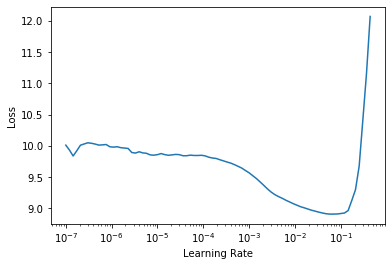

In [15]:
%%time
learn.freeze()
learn.lr_find()

The learning rate finder curve suggests picking a lr min of 6e-3. Let's use 2e-3.

In [16]:
learn.fit_one_cycle(1, 2e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.803344,3.640777,0.325177,38.121441,5:48:31


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



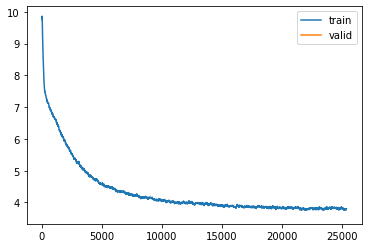

In [101]:
#hide
learn.recorder.plot_loss()

In just **one epoch**, our model passed 
- from an accuracy of 9.90% to **32.52%**
- from a perplexity of 20950.94 to **38.12**

Not too bad! 

Now, We can pass `-2` to `freeze_to` to freeze all except the last two parameter groups.

In [105]:
learn.save(path_data/'GPT2_pt_1epoch_lr2e-3')
learn = learn.load(path_data/'GPT2_pt_1epoch_lr2e-3')

##### 6.2.2 Freeze all layers but the last 2 layers groups

In [19]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-3/(2.6**4),1e-3))

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.453913,3.301886,0.362879,27.163816,5:38:18


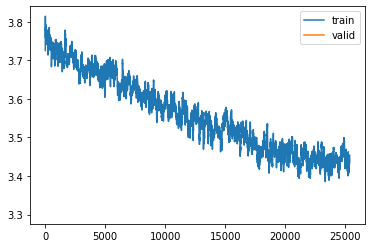

In [20]:
#hide
learn.recorder.plot_loss()

In [58]:
learn.save(path_data/'GPT2_pt_2epoch_lr1e-3')
learn = learn.load(path_data/'GPT2_pt_2epoch_lr1e-3')

##### 6.2.3 Freeze all layers but the last 3 layers groups

In [22]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-4/(2.6**4),5e-4))

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.333389,3.207390,0.374579,24.714487,6:20:51


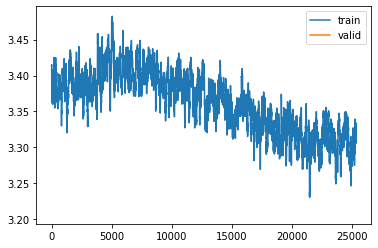

In [23]:
#hide
learn.recorder.plot_loss()

In [24]:
learn.save(path_data/'GPT2_pt_3epoch_lr5e-4')
learn = learn.load(path_data/'GPT2_pt_3epoch_lr5e-4')

##### 6.2.4 Unfreeze all layers

In [20]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-4/(2.6**4),1e-4))

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.288433,3.186721,0.377380,24.208906,6:06:29
1,3.232569,3.167864,0.379885,23.756687,6:16:22


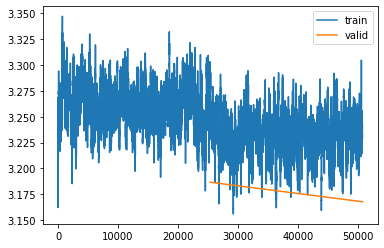

In [21]:
#hide
learn.recorder.plot_loss()

In [22]:
learn.save(path_data/'GPT2_pt_5epoch_lr1e-4_v2')
learn = learn.load(path_data/'GPT2_pt_5epoch_lr1e-4_v2')

## Model sharing and uploading in the Hugging Face model hub

We can share our Portuguese GPT-2 on the Hugging Face [model hub](https://huggingface.co/models) following the tutorial [Model sharing and uploading](https://huggingface.co/transformers/model_sharing.html).

Your model now has a page on huggingface.co/models 🔥

Anyone can load it from code:

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("namespace/awesome-name-you-picked")
model = AutoModel.from_pretrained("namespace/awesome-name-you-picked")

In our case, the code is:

In [ ]:
from transformers import AutoTokenizer, AutoModelWithLMHead

tokenizer = AutoTokenizer.from_pretrained("pierreguillou/gpt2-small-portuguese")
model = AutoModelWithLMHead.from_pretrained("pierreguillou/gpt2-small-portuguese")

Check our [Hugging face model page](https://huggingface.co/pierreguillou/gpt2-small-portuguese) to get more information.

## Text Generation by our Portuguese GPT-2

Now that we have a GPT-2 in Portuguese, we can use it for different tasks in NLP (Text Generation, Reading Comprehension, Translation, Summary) as showed in the post "**GPT-2 use cases: beyond Text Generation**".

For now, let's use it to generate new texts, which allows us to check that it works properly and also have a little fun.

### Text Generation techniques 

**At each stage of text generation, GPT-2 provides a vector of 50.257 probabilities** (each corresponds to a possible token of the vocabulary whose size is 50.257). To decide how to choose the output token from these probabilities, **there are at least 5 methods: Greedy, Beam Search, Sampling with temperature, Top-k sampling and Top-p (nucleus) sampling**.

In this tutorial, we will test only 2 of these text generation methods: **Top-k sampling** and **Top-p (nucleus) sampling**.

Note: to get more information on text generation techniques for transformer-based language model, read the article "[How to generate text: using different decoding methods for language generation with Transformers](https://huggingface.co/blog/how-to-generate)" from [Patrick von Platen](https://huggingface.co/patrickvonplaten) (Hugging Face, 03/18/2020).

#### (Use case 1) Top-k sampling

Our use case 1 follows the same method used by OpenAI in page 20 of the paper [Language Models are Unsupervised Multitask Learners](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf) by choosing **Top-k sampling** text generation technique with a **value of 40**.

This text generation method is implemented in the `model.generate()` function of a Transformers model thanks to the following arguments:
- `top_k` (int): the number of highest probability vocabulary tokens to keep for top-k-filtering. Between 1 and infinity. Default to 50.

#### (Use case 2) Top-p (nucleus) sampling

Our use case 2 follows the [top-p (nucleus) sampling](https://huggingface.co/blog/how-to-generate#top-p-nucleus-sampling) method with Top-p sampling (top_p = 0.95), top-k sampling (top_k = 50), temperature (temperature = 0.7) and repetition penalty (repetition_penalty = 1.2).

This text generation method is implemented in the `model.generate()` function of a Transformers model thanks to the following arguments:
- `top_p` (float): the cumulative probability of parameter highest probability vocabulary tokens to keep for nucleus sampling. Must be between 0 and 1. Default to 1.
- `top_k` (int): the number of highest probability vocabulary tokens to keep for top-k-filtering. Between 1 and infinity. Default to 50.
- `temperature` (float): the value used to module the next token probabilities. Must be strictly positive. Default to 1.0.
- `repetition_penalty` (float): the parameter for repetition penalty. Between 1.0 and infinity. 1.0 means no penalty. Default to 1.0.

### Text n°1 | Famous OpenAI generated text about unicorns

At the time of publication of GPT-2 in the article "[Better Language Models and Their Implications](https://openai.com/blog/better-language-models/)" (02/14/2019), the media retained from its different possibilities in NLP that of text generation because of the now famous text generated on unicorns from this small paragraph:

>In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.

From this text, GPT-2 wrote the following [sample](https://openai.com/blog/better-language-models/#samples) out of 10 tries:

In [6]:
openai_generated_text_en = "In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English. \
\n\nThe scientist named the population, after their distinctive horn, Ovid's Unicorn. These four-horned, silver-white unicorns were previously unknown to science. \
\n\nNow, after almost two centuries, the mystery of what sparked this odd phenomenon is finally solved. \
\n\nDr. Jorge Pérez, an evolutionary biologist from the University of La Paz, and several companions, were exploring the Andes Mountains when they found a small valley, with no other animals or humans. Pérez noticed that the valley had what appeared to be a natural fountain, surrounded by two peaks of rock and silver snow. \
\n\nPérez and the others then ventured further into the valley. “By the time we reached the top of one peak, the water looked blue, with some crystals on top,” said Pérez. \
\n\nPérez and his friends were astonished to see the unicorn herd. These creatures could be seen from the air without having to move too much to see them – they were so close they could touch their horns. \
\n\nWhile examining these bizarre creatures the scientists discovered that the creatures also spoke some fairly regular English. Pérez stated, “We can see, for example, that they have a common ‘language,’ something like a dialect or dialectic.” \
\n\nDr. Pérez believes that the unicorns may have originated in Argentina, where the animals were believed to be descendants of a lost race of people who lived there before the arrival of humans in those parts of South America. \
\n\nWhile their origins are still unclear, some believe that perhaps the creatures were created when a human and a unicorn met each other in a time before human civilization. According to Pérez, “In South America, such incidents seem to be quite common.” \
\n\nHowever, Pérez also pointed out that it is likely that the only way of knowing for sure if unicorns are indeed the descendants of a lost alien race is through DNA. “But they seem to be able to communicate in English quite well, which I believe is a sign of evolution, or at least a change in social organization,” said the scientist."

print(openai_generated_text_en)

In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English. 

The scientist named the population, after their distinctive horn, Ovid's Unicorn. These four-horned, silver-white unicorns were previously unknown to science. 

Now, after almost two centuries, the mystery of what sparked this odd phenomenon is finally solved. 

Dr. Jorge Pérez, an evolutionary biologist from the University of La Paz, and several companions, were exploring the Andes Mountains when they found a small valley, with no other animals or humans. Pérez noticed that the valley had what appeared to be a natural fountain, surrounded by two peaks of rock and silver snow. 

Pérez and the others then ventured further into the valley. “By the time we reached the top of one peak, the water looked blue, with some crystals on top,” said Pérez. 

Pérez and h

#### Reload Portuguese GPT-2

##### English pre-trained GPT-2

In [6]:
%%time
from transformers import GPT2TokenizerFast, GPT2LMHeadModel

pretrained_weights = 'gpt2'
tokenizer_en = GPT2TokenizerFast.from_pretrained(pretrained_weights)
model_en = GPT2LMHeadModel.from_pretrained(pretrained_weights)

Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.attn.masked_bias', 'h.1.attn.masked_bias', 'h.2.attn.masked_bias', 'h.3.attn.masked_bias', 'h.4.attn.masked_bias', 'h.5.attn.masked_bias', 'h.6.attn.masked_bias', 'h.7.attn.masked_bias', 'h.8.attn.masked_bias', 'h.9.attn.masked_bias', 'h.10.attn.masked_bias', 'h.11.attn.masked_bias', 'lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


CPU times: user 14.4 s, sys: 1.8 s, total: 16.2 s
Wall time: 7.72 s


##### Portuguese tokenizer

In [7]:
from transformers import GPT2TokenizerFast

# Get the path to ByteLevelBPE_tokenizer_pt config files
ByteLevelBPE_tokenizer_pt_rep = 'ByteLevelBPE_tokenizer_pt'
path_to_ByteLevelBPE_tokenizer_pt_rep = path_data/ByteLevelBPE_tokenizer_pt_rep

# import the pre-trained GPT2TokenizerFast tokenizer with the tokenizer_pt config files
tokenizer_pt = GPT2TokenizerFast.from_pretrained(
    str(path_to_ByteLevelBPE_tokenizer_pt_rep), 
    pad_token='<|endoftext|>')

# Get sequence length max of 1024
tokenizer_pt.model_max_length = 1024

##### Datasets

In [8]:
class TransformersTokenizer(Transform):
    def __init__(self, tokenizer): self.tokenizer = tokenizer
    def encodes(self, x): 
        toks = self.tokenizer.tokenize(x)
        return tensor(self.tokenizer.convert_tokens_to_ids(toks))
    def decodes(self, x): return TitledStr(self.tokenizer.decode(x.cpu().numpy()))

In [9]:
# get data
lang = 'pt'
fname = f'all_texts_{lang}wiki.csv'
df = pd.read_csv(path_data/fname)

# load idxs train and valid
idxs_train = torch.load(path_data/'idxs_train.pt')
idxs_val = torch.load(path_data/'idxs_val.pt')

all_texts = np.concatenate([df.iloc[idxs_train].text.values, df.iloc[idxs_val].text.values])
splits = [list(idxs_train), list(idxs_val)]
tls = TfmdLists(all_texts, TransformersTokenizer(tokenizer_pt), splits=splits, dl_type=LMDataLoader)

##### Dataloaders

In [10]:
%%time
bs,sl = 8,1024
dls = tls.dataloaders(bs=bs, seq_len=sl)

CPU times: user 27min 56s, sys: 3min 20s, total: 31min 16s
Wall time: 25min 8s


##### Split a GPT2 model in 4 groups for differential learning rates

In [11]:
class DropOutput(Callback):
    def after_pred(self): self.learn.pred = self.pred[0]

In [12]:
def splitter(model):
    "Split a GPT2 `model` in 3 groups for differential learning rates."
    
    # First layers group : decoder blocks from 0 to 3
    modules = []
    for i in range(4): modules.append(model.transformer.h[i])
    groups = [nn.Sequential(*modules)]

    # Second layers group : decoder blocks from 4 to 7
    modules = []
    for i in range(4,8,1): modules.append(model.transformer.h[i])
    groups = L(groups + [nn.Sequential(*modules)])

    # Third layers group : decoder blocks from 8 to 11
    modules = []
    for i in range(8,12,1): modules.append(model.transformer.h[i])
    groups = L(groups + [nn.Sequential(*modules)])
    
    # Fourth layers group : embeddings matrices wte and wpe + LayerNorm at the model output
    groups = L(groups + [nn.Sequential(model.transformer.wte,model.transformer.wpe,model.transformer.ln_f)])
    
    return groups.map(params)

##### Learner

In [13]:
# Learner: basic class for handling the training loop
# source: https://dev.fast.ai/learner#Learner
learn = Learner(dls, model_en, loss_func=CrossEntropyLossFlat(),
                splitter = splitter,
                cbs=[DropOutput], 
                metrics=[accuracy, Perplexity()]).to_fp16()
learn = learn.load(path_data/'GPT2_pt_5epoch_lr1e-4_v2')

In [14]:
# model
model_pt = learn.model

In [15]:
# put model into eval mode and on GPU
model_pt.eval();
model_pt.to('cuda');

#### Get translated famous unicorn text in Portuguese

In [16]:
from transformers import MarianMTModel, MarianTokenizer

In [17]:
# MarianMT Translator
model_name = 'Helsinki-NLP/opus-mt-en-ROMANCE'
tokenizer_en_pt = MarianTokenizer.from_pretrained(model_name)
print(tokenizer_en_pt.supported_language_codes)
model_en_pt = MarianMTModel.from_pretrained(model_name)

['>>fr<<', '>>es<<', '>>it<<', '>>pt<<', '>>pt_br<<', '>>ro<<', '>>ca<<', '>>gl<<', '>>pt_BR<<', '>>la<<', '>>wa<<', '>>fur<<', '>>oc<<', '>>fr_CA<<', '>>sc<<', '>>es_ES<<', '>>es_MX<<', '>>es_AR<<', '>>es_PR<<', '>>es_UY<<', '>>es_CL<<', '>>es_CO<<', '>>es_CR<<', '>>es_GT<<', '>>es_HN<<', '>>es_NI<<', '>>es_PA<<', '>>es_PE<<', '>>es_VE<<', '>>es_DO<<', '>>es_EC<<', '>>es_SV<<', '>>an<<', '>>pt_PT<<', '>>frp<<', '>>lad<<', '>>vec<<', '>>fr_FR<<', '>>co<<', '>>it_IT<<', '>>lld<<', '>>lij<<', '>>lmo<<', '>>nap<<', '>>rm<<', '>>scn<<', '>>mwl<<']


In [18]:
src_text = [
    '>>pt_BR<< In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.',
]
print(src_text)

['>>pt_BR<< In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.']


In [19]:
translated = model_en_pt.generate(**tokenizer_en_pt.prepare_translation_batch(src_text))
tgt_text = [tokenizer_en_pt.decode(t, skip_special_tokens=True) for t in translated]
prompt = tgt_text[0]
prompt

'Num achado chocante, o cientista descobriu uma manada de unicórnios vivendo num vale remoto, anteriormente inexplorado, nas Montanhas dos Andes. Ainda mais surpreendente para os pesquisadores foi o fato de que os unicórnios falavam inglês perfeito.'

#### Get generated text

In [20]:
# Get the number of tokens of the OpenAI English generated text
openai_generated_text_en = "In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English. \
\n\nThe scientist named the population, after their distinctive horn, Ovid's Unicorn. These four-horned, silver-white unicorns were previously unknown to science. \
\n\nNow, after almost two centuries, the mystery of what sparked this odd phenomenon is finally solved. \
\n\nDr. Jorge Pérez, an evolutionary biologist from the University of La Paz, and several companions, were exploring the Andes Mountains when they found a small valley, with no other animals or humans. Pérez noticed that the valley had what appeared to be a natural fountain, surrounded by two peaks of rock and silver snow. \
\n\nPérez and the others then ventured further into the valley. “By the time we reached the top of one peak, the water looked blue, with some crystals on top,” said Pérez. \
\n\nPérez and his friends were astonished to see the unicorn herd. These creatures could be seen from the air without having to move too much to see them – they were so close they could touch their horns. \
\n\nWhile examining these bizarre creatures the scientists discovered that the creatures also spoke some fairly regular English. Pérez stated, “We can see, for example, that they have a common ‘language,’ something like a dialect or dialectic.” \
\n\nDr. Pérez believes that the unicorns may have originated in Argentina, where the animals were believed to be descendants of a lost race of people who lived there before the arrival of humans in those parts of South America. \
\n\nWhile their origins are still unclear, some believe that perhaps the creatures were created when a human and a unicorn met each other in a time before human civilization. According to Pérez, “In South America, such incidents seem to be quite common.” \
\n\nHowever, Pérez also pointed out that it is likely that the only way of knowing for sure if unicorns are indeed the descendants of a lost alien race is through DNA. “But they seem to be able to communicate in English quite well, which I believe is a sign of evolution, or at least a change in social organization,” said the scientist."

openai_generated_text_en_ids = tokenizer_en.encode(openai_generated_text_en, return_tensors='pt').to('cuda')
max_length = openai_generated_text_en_ids.shape[1]

print(max_length)

504


In [21]:
# encode
input_ids = tokenizer_pt.encode(prompt, return_tensors='pt').to('cuda')

##### Use case 1 (Top-k sampling)

In [51]:
%%time
#set top_k = 40 and num_return_sequences = 3
sample_outputs = model_pt.generate(input_ids, pad_token_id=50256,
                                   do_sample=True, 
                                   max_length=max_length, 
                                   min_length=max_length,
                                   top_k=40,
                                   num_return_sequences=3)

for i, sample_output in enumerate(sample_outputs):
    print(">> Generated text {}\n\n{}".format(i+1, tokenizer_pt.decode(sample_output.tolist())))
    print('\n---')

>> Generated text 1

Num achado chocante, o cientista descobriu uma manada de unicórnios vivendo num vale remoto, anteriormente inexplorado, nas Montanhas dos Andes. Ainda mais surpreendente para os pesquisadores foi o fato de que os unicórnios falavam inglês perfeito. Um deles, um escocês chamado Thomas (um anatomista irlandês) que havia trabalhado com o britânico em seu trabalho como assistente do diretor experimental da universidade, John Holley, foi chamado de por eles para um encontro sobre os dois conceitos, que não tinham encontrado muito trabalho até o momento. Eles foram palestrantes, mas ficaram impressionados que Thomas (como todos os outros cientistas da época) não sabia falar Inglês. Quando Thomas fez isso com os unicórnios por engano, Holley a escreveu e enviou um telegrama à BBC perguntando: ""Tão, o que é tal dizer se você quer saber de nenhum outro, eu não sei como ele fala inglês?"" Eles disseram a ele: "Não, mas é um idiota." Então, uma semana depois, no mesmo dia, H

##### Use case 2 (Top-p nucleus sampling)

In [22]:
%%time
#set top_p = 0.95, top_k = 50, temperature = 0.7, repetition_penalty = 1.2 and num_return_sequences = 3
sample_outputs = model_pt.generate(input_ids, pad_token_id=50256,
                                   do_sample=True,
                                   max_length=max_length, 
                                   min_length=max_length,
                                   repetition_penalty=1.2,
                                   temperature=0.7,
                                   top_k=50, 
                                   top_p=0.95, 
                                   num_return_sequences=3)

for i, sample_output in enumerate(sample_outputs):
    print(">> Generated text {}\n\n{}".format(i+1, tokenizer_pt.decode(sample_output.tolist())))
    print('\n---')

>> Generated text 1

Num achado chocante, o cientista descobriu uma manada de unicórnios vivendo num vale remoto, anteriormente inexplorado, nas Montanhas dos Andes. Ainda mais surpreendente para os pesquisadores foi o fato de que os unicórnios falavam inglês perfeito. Eles não sabiam onde exatamente eram falantes nativos do idioma, e acreditaram que eles simplesmente migraram das terras altas da região de Mendoza ao norte como consequência do declínio populacional que ocorreu na Cordilheira das Cobras.

Em 2004, o Departamento de Antropologia da Universidade do Colorado anunciou que havia encontrado uma fêmea no vale do rio Orinoco na Bolívia, mas essa fêmea foi morta durante a investigação. No entanto, no início de 2006, as autoridades locais anunciaram que havia identificado uma fêmea encontrada em uma área próxima à Cordilheira dos Andes, no Vale do Cauca. A equipe de pesquisadores relatou que esta fêmea era chamada de "El Maria" ou "El Maria".

O estudo revelou que o grupo de unic

### Text n°2 | Recent text on the coronavirus disease (Covid-19)

In [54]:
# source (uol, 07/13/2020): https://www.uol.com.br/vivabem/noticias/redacao/2020/07/13/russia-vacina-conclui-testes-distribuicao-em-agosto.htm
prompt = "A Rússia está mais perto de se tornar o primeiro país a iniciar a distribuição de uma vacina contra o coronavírus para a população. O país anunciou hoje que concluiu parte dos testes clínicos necessários para comprovar a eficácia da imunização desenvolvida por iniciativa do governo russo. A expectativa é de que a distribuição comece já em agosto."
print(prompt)

A Rússia está mais perto de se tornar o primeiro país a iniciar a distribuição de uma vacina contra o coronavírus para a população. O país anunciou hoje que concluiu parte dos testes clínicos necessários para comprovar a eficácia da imunização desenvolvida por iniciativa do governo russo. A expectativa é de que a distribuição comece já em agosto.


In [55]:
# encode
input_ids = tokenizer_pt.encode(prompt, return_tensors='pt').to('cuda')

##### Use case 1 (Top-k sampling)

In [56]:
%%time
#set top_k = 40 and num_return_sequences = 3
sample_outputs = model_pt.generate(input_ids, pad_token_id=50256,
                                   do_sample=True, 
                                   max_length=max_length, 
                                   min_length=max_length,
                                   top_k=40,
                                   num_return_sequences=3)

for i, sample_output in enumerate(sample_outputs):
    print(">> Generated text {}\n\n{}".format(i+1, tokenizer_pt.decode(sample_output.tolist())))
    print('\n---')

>> Generated text 1

A Rússia está mais perto de se tornar o primeiro país a iniciar a distribuição de uma vacina contra o coronavírus para a população. O país anunciou hoje que concluiu parte dos testes clínicos necessários para comprovar a eficácia da imunização desenvolvida por iniciativa do governo russo. A expectativa é de que a distribuição comece já em agosto.

Entre os primeiros casos confirmados de COVID-19 na Rússia estava um homem russo com idade entre 50 e 49 anos, segundo o jornal " Moscow" e o primeiro caso em 28 de fevereiro, a primeira no Hospital Pulkai.

No entanto, os primeiros casos foram mais sérios devido sua "maturidade sem gravidade" e a falta de uma pessoa estar disponível para testes de suas condições de vida. Entre os pacientes que foram considerados estão funcionários de um hospital ou enfermeiros na cidade de Moscou (ver abaixo) ou médicos. Depois de serem testados negativos após um teste positivo, o paciente se recupera completamente.

Os russos também anu

##### Use case 2 (Top-p nucleus sampling)

In [58]:
%%time
#set top_p = 0.95, top_k = 50, temperature = 0.7, repetition_penalty = 1.2 and num_return_sequences = 3
sample_outputs = model_pt.generate(input_ids, pad_token_id=50256,
                                   do_sample=True,
                                   max_length=max_length, 
                                   min_length=max_length,
                                   repetition_penalty=1.2,
                                   temperature=0.7,
                                   top_k=50, 
                                   top_p=0.95, 
                                   num_return_sequences=3)

for i, sample_output in enumerate(sample_outputs):
    print(">> Generated text {}\n\n{}".format(i+1, tokenizer_pt.decode(sample_output.tolist())))
    print('\n---')

>> Generated text 1

A Rússia está mais perto de se tornar o primeiro país a iniciar a distribuição de uma vacina contra o coronavírus para a população. O país anunciou hoje que concluiu parte dos testes clínicos necessários para comprovar a eficácia da imunização desenvolvida por iniciativa do governo russo. A expectativa é de que a distribuição comece já em agosto.

A Rússia tem um mercado interno bruto (PIB) estimado entre US$ 1,2 bilhões e US$ 7 bilhões. O PIB "per capita" em 2007 foi de US $ 4,348. A maior parte do crescimento econômico anual ocorreu na agricultura. Em 2003, a taxa média anual era de 22%.

Em 2004, cerca de 3 milhões de pessoas foram infectadas pelo coronavírus. Cerca de 17 mil casos foram identificados entre 2001 e 2002, incluindo aproximadamente 2,8% das crianças e adolescentes com idade inferior a seis anos; 5,1 milhão deles eram endêmicas ou sem cuidados médicos; 8,711 mortes ocorreram nos três primeiros meses de vida após o contato com o vírus; 13,6 mil havia

## Conclusion

We are the first, fortunately surprised by the efficiency of fine-tuning in Portuguese an English pre-trained transformer-based language model like GPT-2 small.

In about 1 day using 1 GPU and a little over 1 GB of Portuguese texts, we managed to obtain a **GPorTuguese-2 capable of generating contextual Portuguese texts of a level comparable to that of the GPT-2 used by OpenAI in 2019**.

Happy.

The next step would be to apply our fine-tuning method to most recent NLP models like GPT-3, BART, T5 or Reformer. Let’s do it?

## END